# **Federated Learning for Patient Mortality Prediction using Neural Networks on MIMIC-III**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preprocessing

In [3]:
# file paths and columns
files = {
    "chartevents": ("mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv", 
                    ["icustay_id", "charttime", "itemid", "valuenum"]),
    "labevents": ("mimic-iii-clinical-database-demo-1.4/LABEVENTS.csv", 
                  ["subject_id", "hadm_id", "charttime", "itemid", "valuenum"]),
    "outputevents": ("mimic-iii-clinical-database-demo-1.4/OUTPUTEVENTS.csv", 
                     ["subject_id", "hadm_id", "charttime", "itemid", "value"]),
    "admissions": ("mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv", 
                   ["subject_id", "admittime"])
}

# Load files dynamically
dfs = {name: pd.read_csv(path, usecols=cols, low_memory=False) for name, (path, cols) in files.items()}

# Access individual DataFrames
df_chartevents = dfs["chartevents"]
df_labevents = dfs["labevents"]
df_outputevents = dfs["outputevents"]
df_admissions = dfs["admissions"]


## Extraction of Clinical Features  
In this section, we will extract all the attributes that we found important to better train our models.

### 1. Extraction of the Glasgow Coma Scale (GCS)  
We extract the components of the Glasgow Coma Scale (verbal, motor, ocular) and calculate the total score, an important neurological indicator.

In [4]:
gcs_items = {
    "GCSVerbal": [723, 223900],
    "GCSMotor": [454, 223901],
    "GCSEyes": [184, 220739]
}
df_gcs = df_chartevents[df_chartevents["itemid"].isin(sum(gcs_items.values(), []))].copy()
df_gcs["Feature"] = df_gcs["itemid"].map({v: k for k, lst in gcs_items.items() for v in lst})
df_gcs = df_gcs.pivot_table(index=["icustay_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_gcs["GCS_Total"] = df_gcs.sum(axis=1)
df_gcs.reset_index(inplace=True)


### 2. Extraction of Vital Signs  
We extract systolic blood pressure, heart rate, and temperature, converting Fahrenheit to Celsius.

In [5]:
vital_signs = {
    "SysBP": [51, 442, 455, 220179, 220050],
    "HeartRate": [211, 220045],
    "Temperature_F": [678, 223761]
}


df_vitals = df_chartevents[df_chartevents["itemid"].isin(sum(vital_signs.values(), []))].copy()
df_vitals["Feature"] = df_vitals["itemid"].map({v: k for k, lst in vital_signs.items() for v in lst})
df_vitals = df_vitals.pivot_table(index=["icustay_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_vitals["Temperature_C"] = (df_vitals["Temperature_F"] - 32) * 5 / 9  
df_vitals.drop(columns=["Temperature_F"], inplace=True)
df_vitals.reset_index(inplace=True)

### 3. Calculation of the PaO₂/FiO₂ Ratio  
We extract the PaO₂ and FiO₂ measurements and then calculate their ratio, a crucial indicator of respiratory function.

In [6]:
# To extract PaO₂ 
df_labevents = pd.read_csv("mimic-iii-clinical-database-demo-1.4/LABEVENTS.csv", low_memory=False)

df_pao2 = df_labevents[df_labevents["itemid"] == 50821].copy()  
df_pao2["Feature"] = "PaO2"
df_pao2 = df_pao2.pivot_table(index=["subject_id", "hadm_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_pao2.reset_index(inplace=True)

# To extract FiO₂ 
df_chartevents = pd.read_csv("mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv", low_memory=False)

fio2_items = [223835, 190]  
df_fio2 = df_chartevents[df_chartevents["itemid"].isin(fio2_items)].copy()
df_fio2["Feature"] = "FiO2"
df_fio2 = df_fio2.pivot_table(index=["subject_id", "hadm_id", "charttime"], columns="Feature", values="valuenum", aggfunc="max")
df_fio2.reset_index(inplace=True)

# Concatenate our two results 
df_pao2_fio2 = pd.merge(df_pao2, df_fio2, on=["subject_id", "hadm_id", "charttime"], how="outer")

df_pao2_fio2["PaO2_FiO2_Ratio"] = df_pao2_fio2["PaO2"] / df_pao2_fio2["FiO2"]

# Replace missing values of PaO₂/FiO₂ Ratio with PaO₂
df_pao2_fio2["PaO2_FiO2_Ratio"] = df_pao2_fio2["PaO2_FiO2_Ratio"].fillna(df_pao2_fio2["PaO2"])

# Save to a CSV file  
df_pao2_fio2.to_csv("processed_pao2_fio2.csv", index=False)

### 4. Extraction of Urine Output  
We extract and aggregate urine output data per patient and period.

In [7]:
# Urine item IDs 
urine_items = [40055, 43175, 40069, 40094, 40715, 40473, 40085, 40057, 40056]

# Extract only the elements containing urine item IDs 
df_urine = df_outputevents[df_outputevents["itemid"].isin(urine_items)].copy()

# Check if 'valuenum' exists; otherwise, use 'value'
if "valuenum" in df_urine.columns:
    value_column = "valuenum"
elif "value" in df_urine.columns:
    value_column = "value"
else:
    raise KeyError("⚠ No valid urine output column found in OUTPUTEVENTS.csv!")

# Group by subject_id, hadm_id, and charttime  
df_urine = df_urine.groupby(["subject_id", "hadm_id", "charttime"])[value_column].sum().reset_index()

# Rename the column 
df_urine.rename(columns={value_column: "UrineOutput"}, inplace=True)

### 5. Extraction of Laboratory Tests  
We extract various laboratory values (white blood cells, bicarbonate, sodium, potassium, bilirubin, BUN).

In [8]:
lab_items = {
    "WBC": [51300],
    "Bicarbonate": [50882],
    "Sodium": [950824, 50983],
    "Potassium": [50822, 50971],
    "Bilirubin": [50885],
    "BUN": [51006]
}

df_labs = df_labevents[df_labevents["itemid"].isin(sum(lab_items.values(), []))].copy()  # Utiliser .copy() pour éviter les avertissements

df_labs["Feature"] = df_labs["itemid"].map({v: k for k, lst in lab_items.items() for v in lst})

# Pivot table using subject_id and hadm_id instead of icustay_id
df_labs = df_labs.pivot_table(index=["subject_id", "hadm_id", "charttime"],
                              columns="Feature", values="valuenum", aggfunc="max")

# Reset index to flatten the DataFrame
df_labs.reset_index(inplace=True)

## Merging and Data Preparation  
### Merging and Preprocessing Data  
We merge all the extracted dataframes from the different tables in the dataset.

In [9]:
dfs = [df_gcs, df_vitals, df_pao2_fio2, df_urine, df_labs]

# Ensure 'subject_id', 'hadm_id', and 'charttime' are present in all DataFrames
for i, df in enumerate(dfs):
    # 1. Add missing columns if they don't exist
    for col in ["subject_id", "hadm_id", "charttime"]:
        if col not in df.columns:
            df[col] = pd.NA

    # 2. Convert to consistent data types
    for col in ["subject_id", "hadm_id"]:
        if df[col].dtype != 'int64':  # Ajuster le type de données
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # 3. Handle 'charttime' - convert to datetime format
    if df["charttime"].dtype != '<M8[ns]':
        df["charttime"] = pd.to_datetime(df["charttime"])

    dfs[i] = df

# Merge all DataFrames on 'subject_id', 'hadm_id', and 'charttime' using an outer join
df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = df_merged.merge(df, on=["subject_id", "hadm_id", "charttime"], how="outer")


print("Merging completed successfully!")

Merging completed successfully!


We handle missing values using multiple techniques and remove outliers.

In [10]:
df_merged.sort_values(["subject_id", "hadm_id", "charttime"], inplace=True)

df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)
df_merged.fillna(df_merged.median(), inplace=True)

outlier_bounds = {
    "SysBP": (50, 250),
    "HeartRate": (30, 200),
    "Temperature_C": (30, 42),
    "PaO2_FiO2_Ratio": (50, 600),
    "UrineOutput": (0, 8000),
    "WBC": (2, 30),
    "Bicarbonate": (5, 45),
    "Sodium": (120, 160),
    "Potassium": (2, 7),
    "Bilirubin": (0.1, 50),
    "BUN": (2, 200),
    "GCS_Total": (3, 15)
}

for col, (low, high) in outlier_bounds.items():
    if col in df_merged.columns:
        df_merged[col] = np.clip(df_merged[col], low, high)

print("Data sorting and cleaning completed successfully!")

Data sorting and cleaning completed successfully!


## Exporting Preprocessed Data

In [11]:
df_merged.to_csv("processed_feature_set_A.csv", index=False)

print("Feature extraction and preprocessing completed. Data saved to 'processed_feature_set_A.csv'.")

Feature extraction and preprocessing completed. Data saved to 'processed_feature_set_A.csv'.


## Creating Mortality Target Variables  
We add three target variables: in-hospital mortality, 48-hour mortality, and 30-day mortality.

In [12]:
# Load Data
df_final = pd.read_csv("processed_feature_set_A.csv")

# Load ADMISSIONS.csv to retrieve DEATHTIME and DISCHTIME
df_admissions = pd.read_csv("mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv",
                            usecols=["subject_id", "hadm_id", "deathtime", "dischtime"])

# Load ICUSTAYS.csv to retrieve INTIME (ICU admission time)
df_icustays = pd.read_csv("mimic-iii-clinical-database-demo-1.4/ICUSTAYS.csv",
                          usecols=["subject_id", "hadm_id", "intime"])

# Load PATIENTS.csv to retrieve DOD (Date of Death)
df_patients = pd.read_csv("mimic-iii-clinical-database-demo-1.4/PATIENTS.csv",
                          usecols=["subject_id", "dod"])

# Convert dates to datetime format
df_admissions["deathtime"] = pd.to_datetime(df_admissions["deathtime"])
df_admissions["dischtime"] = pd.to_datetime(df_admissions["dischtime"])
df_icustays["intime"] = pd.to_datetime(df_icustays["intime"])
df_patients["dod"] = pd.to_datetime(df_patients["dod"])

# Merge with ADMISSIONS (In-hospital mortality)
df_final = df_final.merge(df_admissions, on=["subject_id", "hadm_id"], how="left")

# Merge with PATIENTS (DOD)
df_final = df_final.merge(df_patients, on="subject_id", how="left")

# Merge with ICUSTAYS (INTIME for ICU admission)
df_final = df_final.merge(df_icustays, on=["subject_id", "hadm_id"], how="left")

# Create the in-hospital mortality column
df_final["Mortality"] = df_final["deathtime"].notnull().astype(int)

# Create 48-hour mortality after ICU admission
df_final["Mortality_48h"] = ((df_final["dod"] - df_final["intime"]).dt.total_seconds() / 3600 < 48).astype(int)

# Create 30-day mortality after hospital discharge
df_final["Mortality_30d"] = ((df_final["dod"] - df_final["dischtime"]).dt.days < 30).astype(int)

# Drop unnecessary columns
df_final.drop(columns=["deathtime", "dischtime", "dod", "intime"], inplace=True)

# Save the final dataset
df_final.to_csv("final_dataset_with_mortality.csv", index=False)

# Check label distribution
print(df_final[["Mortality", "Mortality_48h", "Mortality_30d"]].sum())
print(df_final.head())
print("Mortality label addition successfully completed!")


Mortality        5777
Mortality_48h     275
Mortality_30d    6517
dtype: int64
   icustay_id_x            charttime  GCSEyes  GCSMotor  GCSVerbal  GCS_Total  \
0      254635.0  2164-10-23 17:38:00      3.0       4.0        4.0       11.0   
1      254635.0  2164-10-24 00:00:00      3.0       4.0        4.0       11.0   
2      254635.0  2164-10-24 03:00:00      3.0       4.0        4.0       11.0   
3      254635.0  2164-10-25 03:00:00      3.0       4.0        4.0       11.0   
4      254635.0  2164-10-25 09:30:00      3.0       4.0        4.0       11.0   

   subject_id  hadm_id  icustay_id_y  HeartRate  ...  UrineOutput   BUN  \
0       10006   142345      254635.0       72.0  ...        100.0   9.0   
1       10006   142345      254635.0       72.0  ...        100.0   9.0   
2       10006   142345      254635.0       72.0  ...        100.0  11.0   
3       10006   142345      254635.0       72.0  ...         10.0  11.0   
4       10006   142345      254635.0       72.0  ...       

# 2. Preparation for Federated Learning  

## Data Splitting and Shuffling  
The data is divided between survivors and deceased patients.

In [13]:
mortality_0 = df_final[df_final['Mortality'] == 0]
mortality_1 = df_final[df_final['Mortality'] == 1]

They are randomly shuffled.

In [14]:
mortality_0 = mortality_0.sample(frac=1, random_state=42).reset_index(drop=True)
mortality_1 = mortality_1.sample(frac=1, random_state=42).reset_index(drop=True)

## Defining the Number of Clients  
We have chosen 10 clients for federated learning.

In [15]:
num_clients = 10

## Non-IID Distribution Function  
We create a function to distribute the data in a non-identically distributed manner among clients to closely resemble real-world scenarios.

In [16]:
def create_non_iid_distribution(data_0, data_1, num_clients, alpha=0.8):
    np.random.seed(None)  # Random seed for different results

    # Concatenate both classes together and shuffle
    data = pd.concat([data_0, data_1]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure each client gets at least 2 samples
    min_samples_per_client = 2
    total_samples = len(data)

    # Subtract minimum samples already assigned
    remaining_samples = total_samples - (num_clients * min_samples_per_client)

    # Generate proportions for remaining samples
    proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
    counts = (proportions * remaining_samples).astype(int)

    # Ensure rounding errors do not cause a mismatch
    counts[-1] += remaining_samples - counts.sum()

    # Add back the minimum samples to each client
    counts += min_samples_per_client

    client_data = []
    start_idx = 0

    for i in range(num_clients):
        end_idx = start_idx + counts[i]
        client_df = data.iloc[start_idx:end_idx].sample(frac=1, random_state=i)  # Shuffle
        client_data.append(client_df.reset_index(drop=True))
        start_idx = end_idx

    return client_data

# Applying Non-IID Distribution  
We apply the non-IID distribution with an alpha parameter of 0.8.

In [17]:
client_data = create_non_iid_distribution(mortality_0, mortality_1, num_clients, alpha=0.8)

# Visualization of Distribution  
We visualize and save the distribution of classes among the clients.

Distribution of classes across clients:
Client 1:
  Class 0 (Survived): 1027 samples (79.2%)
  Class 1 (Died): 269 samples (20.8%)
  Total: 1296 samples
------------------------------
Client 2:
  Class 0 (Survived): 2573 samples (80.2%)
  Class 1 (Died): 637 samples (19.8%)
  Total: 3210 samples
------------------------------
Client 3:
  Class 0 (Survived): 5121 samples (79.8%)
  Class 1 (Died): 1298 samples (20.2%)
  Total: 6419 samples
------------------------------
Client 4:
  Class 0 (Survived): 1931 samples (80.8%)
  Class 1 (Died): 458 samples (19.2%)
  Total: 2389 samples
------------------------------
Client 5:
  Class 0 (Survived): 2494 samples (79.8%)
  Class 1 (Died): 630 samples (20.2%)
  Total: 3124 samples
------------------------------
Client 6:
  Class 0 (Survived): 1696 samples (79.5%)
  Class 1 (Died): 438 samples (20.5%)
  Total: 2134 samples
------------------------------
Client 7:
  Class 0 (Survived): 3530 samples (79.8%)
  Class 1 (Died): 892 samples (20.2%)
  To

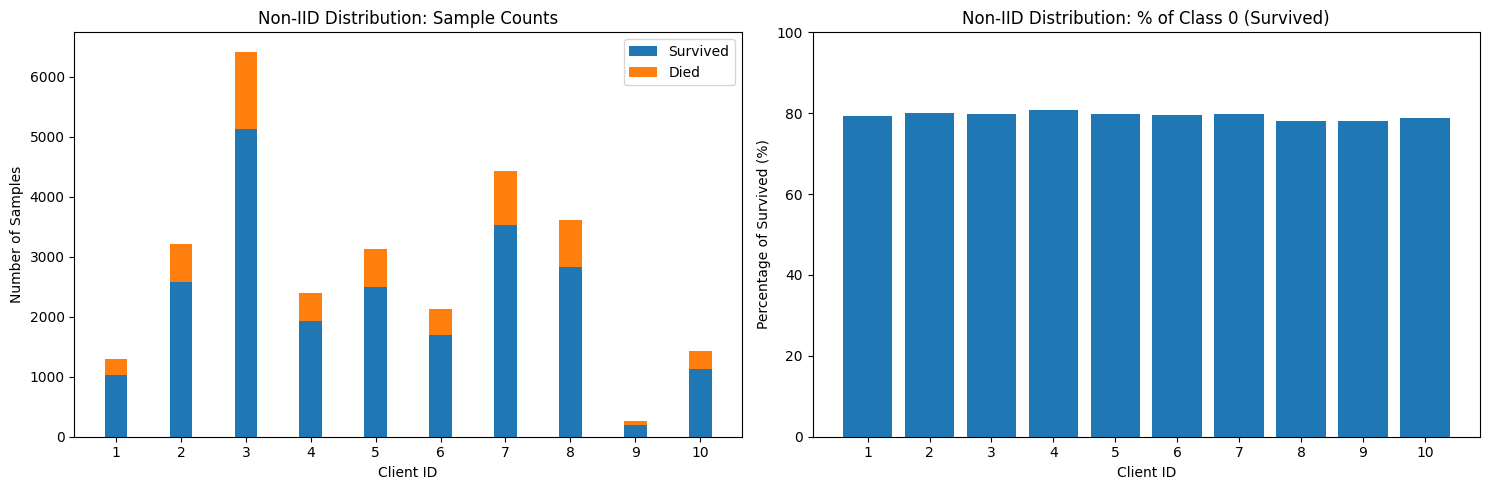

Non-IID data partitioning complete with 10 clients.


In [18]:
def visualize_distribution(client_data):
    # Prepare data for plotting
    class_0_counts = []
    class_1_counts = []
    class_0_percent = []
    total_samples = []

    print("Distribution of classes across clients:")
    for i, client in enumerate(client_data):
        counts = client['Mortality'].value_counts().to_dict()
        count_0 = counts.get(0, 0)
        count_1 = counts.get(1, 0)
        total = len(client)

        class_0_counts.append(count_0)
        class_1_counts.append(count_1)
        class_0_percent.append(100 * count_0 / total)
        total_samples.append(total)

        print(f"Client {i+1}:")
        print(f"  Class 0 (Survived): {count_0} samples ({count_0/total:.1%})")
        print(f"  Class 1 (Died): {count_1} samples ({count_1/total:.1%})")
        print(f"  Total: {total} samples")
        print("-" * 30)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot raw counts
    x = np.arange(num_clients)
    width = 0.35
    ax1.bar(x, class_0_counts, width, label='Survived')
    ax1.bar(x, class_1_counts, width, bottom=class_0_counts, label='Died')
    ax1.set_xlabel('Client ID')
    ax1.set_ylabel('Number of Samples')
    ax1.set_title('Non-IID Distribution: Sample Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{i+1}' for i in range(num_clients)])
    ax1.legend()

    # Plot percentage of class 0
    ax2.bar(x, class_0_percent)
    ax2.set_xlabel('Client ID')
    ax2.set_ylabel('Percentage of Survived (%)')
    ax2.set_title('Non-IID Distribution: % of Class 0 (Survived)')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{i+1}' for i in range(num_clients)])
    ax2.set_ylim(0, 100)

    plt.tight_layout()
    plt.savefig('non_iid_distribution.png', dpi=300)
    plt.show()

# Visualize the non-IID distribution
visualize_distribution(client_data)

for i, client_df in enumerate(client_data):
    client_df.to_csv(f"client_{i+1}_data.csv", index=False)

print(f"Non-IID data partitioning complete with {num_clients} clients.")

# 3. Implementation of Federated Learning  
## PyTorch Setup  
We import the necessary libraries.

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Neural Network Definition  
We create a class for a two-layer neural network with dropout regularization.

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        """
        Initialize the NeuralNetwork model.

        Args:
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden layer.
            output_dim (int): Number of output classes (1 for binary classification).
            dropout_prob (float): Dropout probability for regularization (default: 0.5).
        """
        super(NeuralNetwork, self).__init__()  # Initialize the parent class (nn.Module)

        # First fully connected layer (input to hidden layer)
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        # Initialize weights using Kaiming (He) initialization for ReLU activation
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")

        # Second fully connected layer (hidden layer to output layer)
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
        # Initialize weights using Xavier (Glorot) initialization for the output layer
        nn.init.xavier_uniform_(self.layer_2.weight)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.layer_1(x))

        # Apply dropout for regularization
        x = self.dropout(x)

        # Apply the second fully connected layer
        x = self.layer_2(x)

        return x

## Client Class for Federated Learning  
We define a client class with methods for data preparation, training, and model evaluation.

In [21]:
class FederatedClient:
    def __init__(self, client_id, train_data, test_data, input_dim, hidden_dim, output_dim, dropout_prob=0.5, lr=0.001):
        """
        Initialize a federated learning client.

        Args:
            client_id (str): Unique identifier for the client.
            train_data (tuple): Tuple of (features, labels) for training data.
            test_data (tuple): Tuple of (features, labels) for test data.
            input_dim (int): Number of input features.
            hidden_dim (int): Number of neurons in the hidden layer.
            output_dim (int): Number of output classes (1 for binary classification).
            dropout_prob (float): Dropout probability for regularization (default: 0.5).
            lr (float): Learning rate for the optimizer (default: 0.001).
        """
        self.client_id = client_id
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        self.lr = lr

        # Prepare training and test data
        self.train_loader = self._prepare_data(train_data)
        self.test_loader = self._prepare_data(test_data)

        # Initialize the local model
        self.model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob)
        self.criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def _prepare_data(self, data):
        """
        Convert raw data into a PyTorch DataLoader.

        Args:
            data (tuple): Tuple of (features, labels).

        Returns:
            DataLoader: PyTorch DataLoader for the given data.
        """
        features, labels = data
        dataset = TensorDataset(torch.tensor(features, dtype=torch.float32),
                               torch.tensor(labels, dtype=torch.float32).reshape(-1, 1))
        return DataLoader(dataset, batch_size=32, shuffle=True)

    def train(self, global_model_weights):
        """
        Train the local model using the client's data.

        Args:
            global_model_weights (dict): State dictionary of the global model weights.

        Returns:
            dict: Updated local model weights.
        """
        # Load the global model weights into the local model
        self.model.load_state_dict(global_model_weights)
        self.model.train()

        # Local training loop
        for epoch in range(10):  # Train for 10 epochs (can be adjusted)
            for batch_x, batch_y in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()

        # Return the updated model weights
        return self.model.state_dict()

    def evaluate(self):
        """
        Evaluate the local model on the client's test data.

        Returns:
            float: Accuracy of the model on the test data.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in self.test_loader:
                outputs = self.model(batch_x)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        accuracy = 100 * correct / total
        return accuracy
    def evaluate_train(self):
      """
      Evaluate the local model on the training data.
      Returns:  
          `float`: Accuracy on the training set.
      """
      self.model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_x, batch_y in self.train_loader:
              outputs = self.model(batch_x)
              predicted = (torch.sigmoid(outputs) > 0.5).float()
              total += batch_y.size(0)
              correct += (predicted == batch_y).sum().item()
      return 100 * correct / total
    def calculate_loss(self, data_loader):
      """
      Computes the model's average loss on a given DataLoader.

      Args:
          data_loader (DataLoader):  DataLoader containing the data for evaluation.

      Returns:
          float: Average loss.
      """
      self.model.eval()
      total_loss = 0.0
      total_samples = 0

      with torch.no_grad():
          for batch_x, batch_y in data_loader:
              outputs = self.model(batch_x)
              loss = self.criterion(outputs, batch_y)
              total_loss += loss.item() * batch_y.size(0)
              total_samples += batch_y.size(0)

      return total_loss / total_samples



## Server Class for Federated Learning  
We define the server class, which aggregates model weights and orchestrates the learning process.

In [22]:
class FederatedServer:
    def __init__(self, global_model, clients):
        """
        Initialize the federated learning server.

        Args:
            global_model (nn.Module): The global model to be trained.
            clients (list): List of FederatedClient instances.
        """
        self.global_model = global_model
        self.clients = clients

    def aggregate_weights(self, client_weights):
        """
        Aggregate client model weights using Federated Averaging.

        Args:
            client_weights (list): List of state dictionaries from clients.

        Returns:
            dict: Aggregated global model weights.
        """
        global_weights = self.global_model.state_dict()

        # Average the weights
        for key in global_weights:
            global_weights[key] = torch.stack([client_weights[i][key] for i in range(len(client_weights))]).mean(0)

        return global_weights

    def run_federated_learning(self, num_rounds):
        """
        Run the federated learning process for a specified number of rounds.

        Args:
            num_rounds (int): Number of federated learning rounds.
        """
        for round in range(num_rounds):
            print(f"Round {round + 1}/{num_rounds}")

            # List to store updated weights from clients
            client_weights = []

            # Train each client and collect updated weights
            for client in self.clients:
                print(f"Training {client.client_id}...")
                updated_weights = client.train(self.global_model.state_dict())
                client_weights.append(updated_weights)

                # Evaluate the client's model
                accuracy = client.evaluate()
                print(f"{client.client_id} Test Accuracy: {accuracy:.2f}%")

            # Aggregate client weights to update the global model
            global_weights = self.aggregate_weights(client_weights)
            self.global_model.load_state_dict(global_weights)

            # Evaluate the global model on all clients' test data
            global_accuracy = self.evaluate_global_model()
            print(f"Global Model Test Accuracy: {global_accuracy:.2f}%")

    def evaluate_global_model(self):
        """
        Evaluate the global model on all clients' test data.

        Returns:
            float: Average accuracy of the global model across all clients.
        """
        self.global_model.eval()
        total_accuracy = 0

        for client in self.clients:
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_x, batch_y in client.test_loader:
                    outputs = self.global_model(batch_x)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()

            accuracy = 100 * correct / total
            total_accuracy += accuracy

        return total_accuracy / len(self.clients)

# Tracking Metrics and Early Stopping  
This function orchestrates the federated learning process by collecting performance metrics (accuracy, loss) on training and test sets at each round. It also implements an early stopping mechanism that halts training when performance no longer improves sufficiently.

In [23]:
def run_federated_learning_with_metrics_and_early_stopping(federated_server, max_rounds=10, patience=3, min_improvement=0.001):
    """  
    Runs federated learning by collecting train/test metrics and implementing early stopping.  
    """
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []
    history = []
    best_accuracy = 0
    rounds_without_improvement = 0

    for round_num in range(max_rounds):
        print(f"Round {round_num + 1}/{max_rounds}")

        #  List to store client weights
        client_weights = []

        # Train each client and collect metrics
        round_train_accuracies = []
        round_test_accuracies = []
        round_train_losses = []
        round_test_losses = []

        for client in federated_server.clients:
            updated_weights = client.train(federated_server.global_model.state_dict())
            client_weights.append(updated_weights)

            # Evaluate on train and test sets
            train_acc = client.evaluate_train()
            test_acc = client.evaluate()

            # Compute losses
            train_loss = client.calculate_loss(client.train_loader)
            test_loss = client.calculate_loss(client.test_loader)

            round_train_accuracies.append(train_acc)
            round_test_accuracies.append(test_acc)
            round_train_losses.append(train_loss)
            round_test_losses.append(test_loss)

        # Aggregate weights as before
        global_weights = federated_server.aggregate_weights(client_weights)
        federated_server.global_model.load_state_dict(global_weights)

        # Compute average accuracies for this round
        avg_train_accuracy = sum(round_train_accuracies) / len(round_train_accuracies)
        avg_test_accuracy = sum(round_test_accuracies) / len(round_test_accuracies)

        # Compute average losses
        avg_train_loss = sum(round_train_losses) / len(round_train_losses)
        avg_test_loss = sum(round_test_losses) / len(round_test_losses)

        train_accuracies.append(avg_train_accuracy)
        test_accuracies.append(avg_test_accuracy)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        # Evaluate the global model for early stopping
        global_accuracy = federated_server.evaluate_global_model()
        history.append(global_accuracy)

        # Check for early stopping
        if global_accuracy > best_accuracy + min_improvement:
            best_accuracy = global_accuracy
            rounds_without_improvement = 0
        else:
            rounds_without_improvement += 1
            print(f"No significant improvement. Rounds without improvement: {rounds_without_improvement}/{patience}")
            if rounds_without_improvement >= patience:
                print(f"Early stopping after {round_num + 1} rounds")
                break

    # Visualize train vs test accuracy
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy (%)')
    plt.title("Performance Evolution on Training and Test Sets")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualiser les courbes de loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.title("Loss Evolution During Federated Learning")
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_accuracies, test_accuracies, train_losses, test_losses, history


# Initialization and Launch of Federated Learning  
Final step of our federated learning implementation. It includes:  

- Preparing the data for each client (separating features and labels)  
- Initializing the global model with the previously defined dimensions  
- Creating instances of federated clients with their respective data  
- Initializing the federated server that will orchestrate the learning process  
- Launching the federated learning process over multiple rounds

Modèle global initialisé avec 17 caractéristiques d'entrée, 64 neurones cachés
Client_1 initialisé avec 1036 échantillons d'entraînement et 260 échantillons de test
Client_2 initialisé avec 2568 échantillons d'entraînement et 642 échantillons de test
Client_3 initialisé avec 5135 échantillons d'entraînement et 1284 échantillons de test
Client_4 initialisé avec 1911 échantillons d'entraînement et 478 échantillons de test
Client_5 initialisé avec 2499 échantillons d'entraînement et 625 échantillons de test
Client_6 initialisé avec 1707 échantillons d'entraînement et 427 échantillons de test
Client_7 initialisé avec 3537 échantillons d'entraînement et 885 échantillons de test
Client_8 initialisé avec 2892 échantillons d'entraînement et 724 échantillons de test
Client_9 initialisé avec 208 échantillons d'entraînement et 52 échantillons de test
Client_10 initialisé avec 1146 échantillons d'entraînement et 287 échantillons de test
Federated server initialized

Starting federated learning...


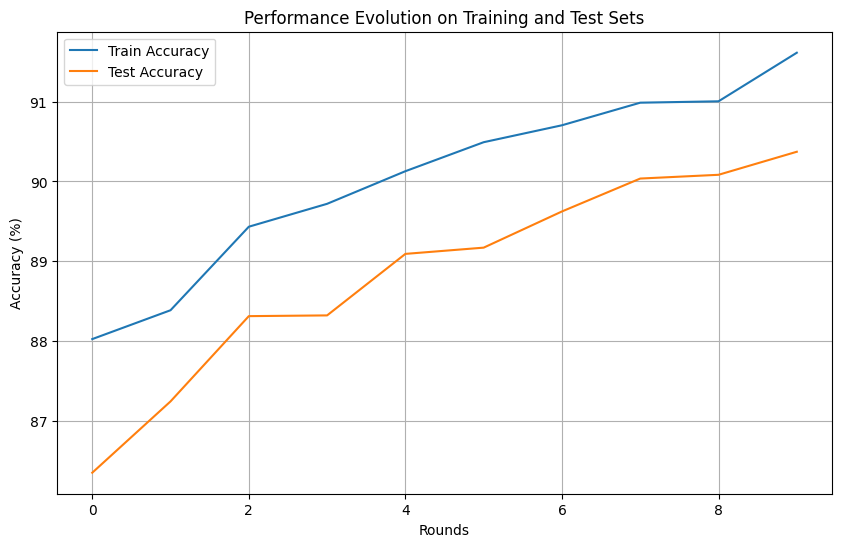

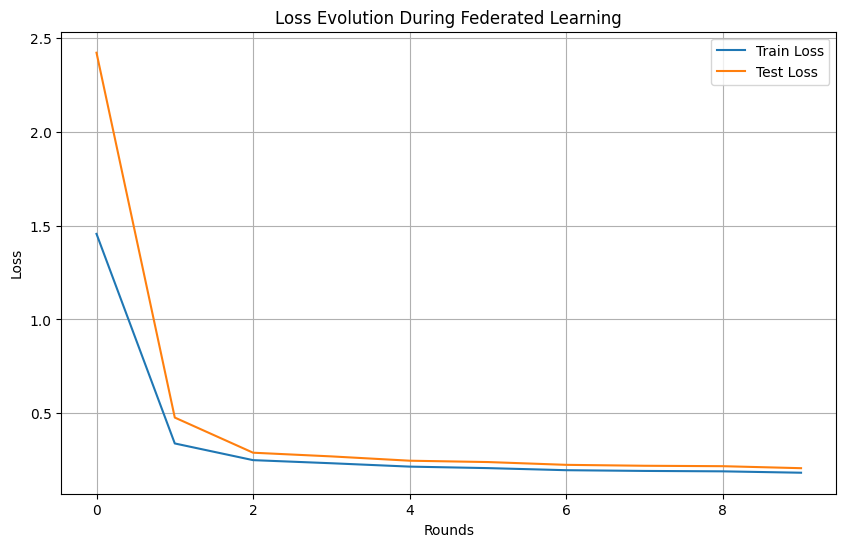

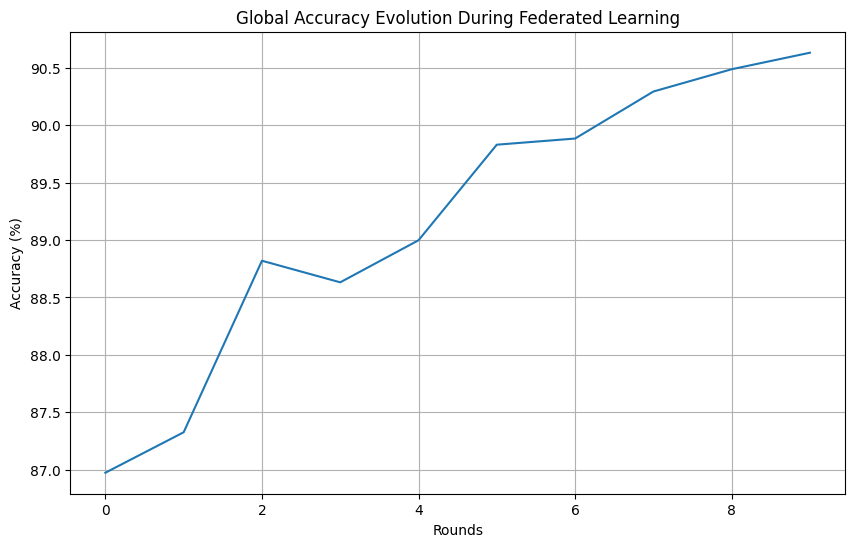

In [24]:
# Data Preparation for Each Client
client_datasets = []

for client_df in client_data:
    # Selecting features and target
    X = client_df.drop(['Mortality', 'Mortality_48h', 'Mortality_30d', 'icustay_id_x', 'charttime', 'subject_id', 'hadm_id', 'icustay_id_y'], axis=1).values
    y = client_df['Mortality'].values

    # Splitting into training and test sets (80% / 20%)  
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    client_datasets.append(((X_train, y_train), (X_test, y_test)))

# Initializing the global model
# Retrieving the actual number of features from the data
if len(client_datasets) > 0 and len(client_datasets[0]) > 0:
    input_dim = client_datasets[0][0][0].shape[1]  # Nombre de caractéristiques
    hidden_dim = 64  # Plus grand modèle pour des données complexes
    output_dim = 1   # Classification binaire (survie/décès)

# Creating the global model
global_model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob=0.3)
print(f"Modèle global initialisé avec {input_dim} caractéristiques d'entrée, {hidden_dim} neurones cachés")

# Initializing federated clients
federated_clients = []
for i, dataset in enumerate(client_datasets):
    client = FederatedClient(
        client_id=f"Client_{i+1}",
        train_data=dataset[0],
        test_data=dataset[1],
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        dropout_prob=0.3,
        lr=0.001
    )
    federated_clients.append(client)
    print(f"Client_{i+1} initialisé avec {len(dataset[0][0])} échantillons d'entraînement et {len(dataset[1][0])} échantillons de test")

# Initializing the federated server
federated_server = FederatedServer(global_model, federated_clients)
print("Federated server initialized")

# Launching federated learning (5 rounds)
print("\nStarting federated learning...")
# Using early stopping
train_accuracies, test_accuracies, train_losses, test_losses, history = run_federated_learning_with_metrics_and_early_stopping(federated_server, max_rounds=10, patience=3)

# Visualizing accuracy evolution
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.title('Global Accuracy Evolution During Federated Learning')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()



# Accuracy Evaluation in Federated Learning  
Evaluation of the accuracy of the federated model. In federated learning, accuracy evaluation is unique because it must aggregate performance across multiple clients without sharing raw data. We will:  

- Create a global evaluation function that aggregates client metrics  
- Evaluate the federated model on test data from all clients  
- Compare the performance of the federated model with a centralized model (as a reference)  
- Visualize accuracy results per client and globally

=== Federated Model Evaluation ===
Client_1: Accuracy = 0.9038 (on 260 samples)
Client_2: Accuracy = 0.9112 (on 642 samples)
Client_3: Accuracy = 0.9026 (on 1284 samples)
Client_4: Accuracy = 0.8828 (on 478 samples)
Client_5: Accuracy = 0.8912 (on 625 samples)
Client_6: Accuracy = 0.8993 (on 427 samples)
Client_7: Accuracy = 0.8881 (on 885 samples)
Client_8: Accuracy = 0.9116 (on 724 samples)
Client_9: Accuracy = 0.9231 (on 52 samples)
Client_10: Accuracy = 0.9233 (on 287 samples)

=== Global Results ===
Weighted Average Accuracy: 0.9006
Global Accuracy: 0.9040
Precision: 0.8201
Recall: 0.6874
F1 Score: 0.7479

=== Training a Centralized Model (Reference) ===
Epoch 2/10, Loss: 5.4579
Epoch 4/10, Loss: 0.9979
Epoch 6/10, Loss: 0.3758
Epoch 8/10, Loss: 0.3076
Epoch 10/10, Loss: 0.2861

=== Centralized Model Results ===
Accuracy: 0.8932
Precision: 0.7803
Recall: 0.6746
F1 Score: 0.7236


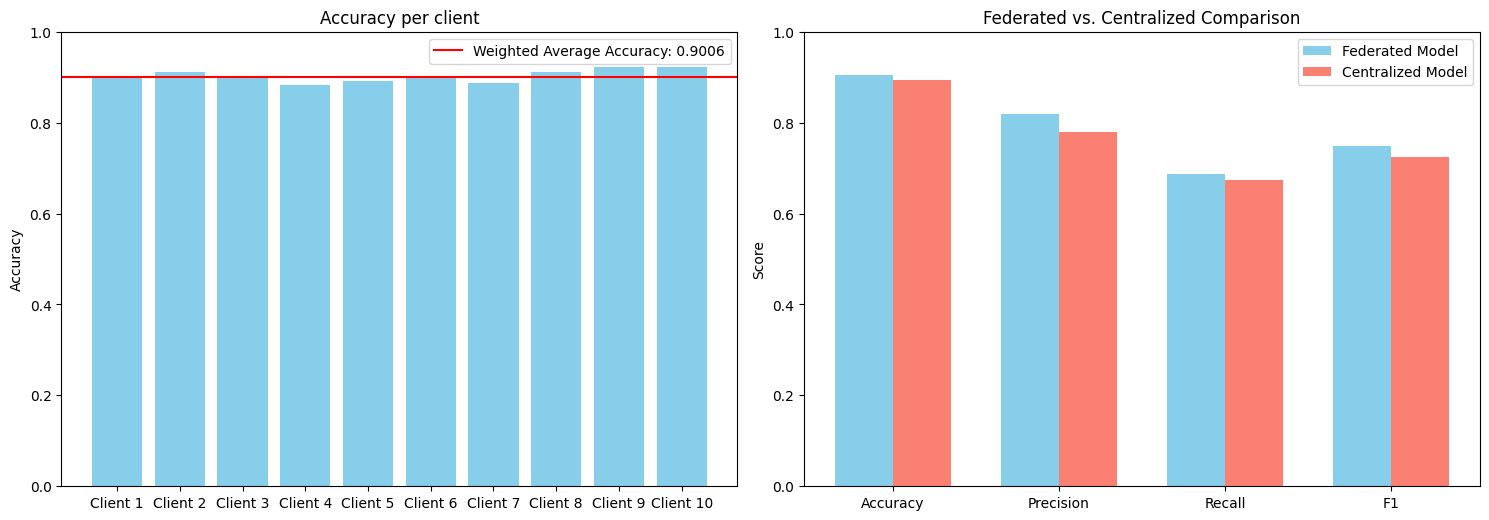

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_raw_data(self):
    """
    Retrieve raw data from the DataLoader for external evaluations.

    Returns:
        tuple: (X_test, y_test) containing test features and labels
    """
    X_test_list = []
    y_test_list = []

    # Iterate through the DataLoader to extract all data
    for features, labels in self.test_loader:
        X_test_list.append(features.numpy())
        y_test_list.append(labels.numpy())

     # Concatenate all batches
    X_test = np.vstack(X_test_list)
    y_test = np.vstack(y_test_list).reshape(-1)

    return X_test, y_test

# Dynamically add the method to the class
FederatedClient.get_raw_data = get_raw_data

# Function to evaluate the federated model globally
def evaluate_federated_model():
    print("=== Federated Model Evaluation ===")

    # Results per client 
    client_accuracies = []
    client_sizes = []

    # Other global metrics
    all_y_true = []
    all_y_pred = []

    # Evaluation per client
    for client in federated_clients:
        local_accuracy = client.evaluate() / 100  # Convertir pourcentage en fraction
        X_test, y_test = client.get_raw_data()
        client_sizes.append(len(X_test))

        # Apply the global model to the data to get predictions
        client.model.load_state_dict(global_model.state_dict())
        client.model.eval()

        with torch.no_grad():
            outputs = client.model(torch.tensor(X_test, dtype=torch.float32))
            y_pred = (torch.sigmoid(outputs) > 0.5).float().numpy().reshape(-1)

       # Store local accuracy
        client_accuracies.append(local_accuracy)

        # Collect for global metrics
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        print(f"{client.client_id}: Accuracy = {local_accuracy:.4f} (on {len(X_test)} samples)")

    # Compute weighted average (by sample size)
    weighted_avg_accuracy = sum(acc * size for acc, size in zip(client_accuracies, client_sizes)) / sum(client_sizes)

    # Global metrics
    global_accuracy = accuracy_score(all_y_true, all_y_pred)
    global_precision = precision_score(all_y_true, all_y_pred, zero_division=0)
    global_recall = recall_score(all_y_true, all_y_pred, zero_division=0)
    global_f1 = f1_score(all_y_true, all_y_pred, zero_division=0)

    print("\n=== Global Results ===")
    print(f"Weighted Average Accuracy: {weighted_avg_accuracy:.4f}")
    print(f"Global Accuracy: {global_accuracy:.4f}")
    print(f"Precision: {global_precision:.4f}")
    print(f"Recall: {global_recall:.4f}")
    print(f"F1 Score: {global_f1:.4f}")


    # Return metrics for comparison or visualization
    return {
        'client_accuracies': client_accuracies,
        'weighted_avg_accuracy': weighted_avg_accuracy,
        'global_accuracy': global_accuracy,
        'global_precision': global_precision,
        'global_recall': global_recall,
        'global_f1': global_f1
    }

# Train a centralized model for comparison
def train_centralized_model():
    print("\n=== Training a Centralized Model (Reference) ===")

     # Combine data from all clients
    X_train_all = []
    y_train_all = []
    X_test_all = []
    y_test_all = []

    for client in federated_clients:
        # Extract raw data from each client
        for batch_x, batch_y in client.train_loader:
            X_train_all.append(batch_x.numpy())
            y_train_all.append(batch_y.numpy())

        X_test, y_test = client.get_raw_data()
        X_test_all.append(X_test)
        y_test_all.append(y_test)

    X_train_all = np.vstack(X_train_all)
    y_train_all = np.vstack(y_train_all).reshape(-1, 1)
    X_test_all = np.vstack(X_test_all)
    y_test_all = np.concatenate(y_test_all)

    # Create and train a centralized model
    centralized_model = NeuralNetwork(input_dim, hidden_dim, output_dim, dropout_prob=0.3)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(centralized_model.parameters(), lr=0.001)

    # Convert data to tensors
    X_train_tensor = torch.FloatTensor(X_train_all)
    y_train_tensor = torch.FloatTensor(y_train_all)

    # Create a DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # Training
    epochs = 10

    for epoch in range(epochs):
        centralized_model.train()
        epoch_loss = 0
        num_batches = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = centralized_model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f}")

    # Evaluate the centralized model
    X_test_tensor = torch.FloatTensor(X_test_all)
    y_test_tensor = torch.FloatTensor(y_test_all).reshape(-1, 1)

    centralized_model.eval()
    with torch.no_grad():
        y_pred_proba = centralized_model(X_test_tensor)
        y_pred = (torch.sigmoid(y_pred_proba) > 0.5).float().numpy().reshape(-1)

    centralized_accuracy = accuracy_score(y_test_all, y_pred)
    centralized_precision = precision_score(y_test_all, y_pred, zero_division=0)
    centralized_recall = recall_score(y_test_all, y_pred, zero_division=0)
    centralized_f1 = f1_score(y_test_all, y_pred, zero_division=0)

    print("\n=== Centralized Model Results ===")
    print(f"Accuracy: {centralized_accuracy:.4f}")
    print(f"Precision: {centralized_precision:.4f}")
    print(f"Recall: {centralized_recall:.4f}")
    print(f"F1 Score: {centralized_f1:.4f}")

    return {
        'accuracy': centralized_accuracy,
        'precision': centralized_precision,
        'recall': centralized_recall,
        'f1': centralized_f1
    }

# Comparative visualization of results
def visualize_results(federated_metrics, centralized_metrics):
    plt.figure(figsize=(15, 10))

    # Graphique 1: Accuracy per client
    plt.subplot(2, 2, 1)
    client_ids = [f"Client {i+1}" for i in range(len(federated_metrics['client_accuracies']))]
    plt.bar(client_ids, federated_metrics['client_accuracies'], color='skyblue')
    plt.axhline(y=federated_metrics['weighted_avg_accuracy'], color='r', linestyle='-', label=f"Weighted Average Accuracy: {federated_metrics['weighted_avg_accuracy']:.4f}")
    plt.title('Accuracy per client')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()

    # Graphique 2: Federated vs. Centralized Comparison
    plt.subplot(2, 2, 2)
    comparison_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    federated_values = [federated_metrics['global_accuracy'], federated_metrics['global_precision'],
                         federated_metrics['global_recall'], federated_metrics['global_f1']]
    centralized_values = [centralized_metrics['accuracy'], centralized_metrics['precision'],
                          centralized_metrics['recall'], centralized_metrics['f1']]

    x = np.arange(len(comparison_metrics))
    width = 0.35

    plt.bar(x - width/2, federated_values, width, label='Federated Model', color='skyblue')
    plt.bar(x + width/2, centralized_values, width, label='Centralized Model', color='salmon')
    plt.title('Federated vs. Centralized Comparison')
    plt.xticks(x, comparison_metrics)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.savefig('federated_vs_centralized_performance.png')
    plt.show()

# Exécuter l'évaluation
federated_metrics = evaluate_federated_model()
centralized_metrics = train_centralized_model()
visualize_results(federated_metrics, centralized_metrics)


In [27]:
# 🧠 Auto-detect model object before using LIME
import inspect

# Try to find any variable in globals that looks like a model
possible_models = [v for k, v in globals().items() if "model" in k.lower()]
if possible_models:
    model = possible_models[0]
    print(f"✅ Found model variable: { [k for k in globals().keys() if globals()[k] is model][0] }")
else:
    raise ValueError("❌ Couldn't find any model variable. Please assign your trained model to a variable named 'model'.")


✅ Found model variable: global_model


In [44]:
# 🔍 LIME Explainability — Fully compatible with your NeuralNetwork model
# !pip install lime ipython --quiet

import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML
import torch
import torch.nn.functional as F

# ✅ 1. Auto-detect model
possible_models = [v for k, v in globals().items() if "model" in k.lower()]
if not possible_models:
    raise ValueError("❌ No model found. Train or define your model first.")
global_model = possible_models[0]
print(f"✅ Using model: { [k for k,v in globals().items() if v is global_model][0] }")

# ✅ 2. Auto-detect test data
candidates_x = [k for k in globals().keys() if "x_test" in k.lower()]
if not candidates_x:
    raise ValueError("❌ Couldn’t find any variable like X_test.")
X_test = np.array(globals()[candidates_x[0]])
print(f"✅ Found X_test as '{candidates_x[0]}'")

candidates_y = [k for k in globals().keys() if "y_test" in k.lower()]
if not candidates_y:
    raise ValueError("❌ Couldn’t find any variable like y_test.")
y_test = np.array(globals()[candidates_y[0]])
print(f"✅ Found y_test as '{candidates_y[0]}'")

# ✅ 3. Define robust prediction wrapper
def predict_proba_wrapper(X):
    global_model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = global_model(inputs)
        
        # 🧠 Convert to probabilities properly
        if outputs.dim() == 1 or outputs.shape[1] == 1:
            # Binary: shape [N, 1] → convert to [N, 2]
            probs = torch.sigmoid(outputs.view(-1, 1))
            probs = torch.cat((1 - probs, probs), dim=1)
        else:
            # Multiclass: apply softmax
            probs = F.softmax(outputs, dim=1)
        return probs.numpy()

# ✅ 4. LIME explainer setup
feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]
class_names = [str(i) for i in np.unique(y_test)]

explainer = LimeTabularExplainer(
    training_data=X_test,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification"
)

# ✅ 5. Pick random sample & explain
sample_index = np.random.randint(0, len(X_test))
sample = X_test[sample_index]
true_label = y_test[sample_index]

exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=predict_proba_wrapper,
    num_features=10
)

print(f"✅ Explaining sample index: {sample_index}, True Label: {true_label}")

# ✅ 6. Display explanation
try:
    # Force inline HTML display (white background)
    html = exp.as_html()
    styled_html = f"""
    <div style='background-color:white; color:black; padding:20px;'>
        {html}
    </div>
    """
    display(HTML(styled_html))
except Exception as e:
    print(f"⚠️ HTML display unavailable ({e}), showing Matplotlib plot instead.")
    fig = exp.as_pyplot_figure()
    fig.patch.set_facecolor('white')
    plt.rcParams.update({'axes.facecolor': 'white', 'figure.facecolor': 'white'})
    plt.show()


✅ Using model: global_model
✅ Found X_test as 'X_test'
✅ Found y_test as 'y_test'
✅ Explaining sample index: 203, True Label: 1


✅ Using model: global_model
✅ Found X_test as 'X_test'
✅ Found y_test as 'y_test'
🧠 Computing SHAP values...
✅ Explaining sample index: 91, class: 1


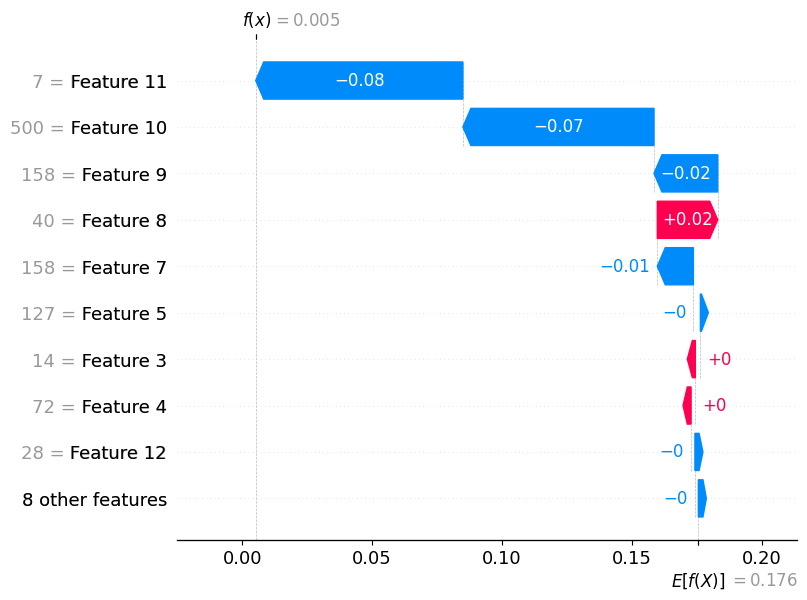

/var/folders/_n/6p_p5pmd6bl1f_9yc8hqn8f40000gn/T/ipykernel_6137/2067957751.py:78: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, class_to_show], X_sample, plot_type="bar", show=True)


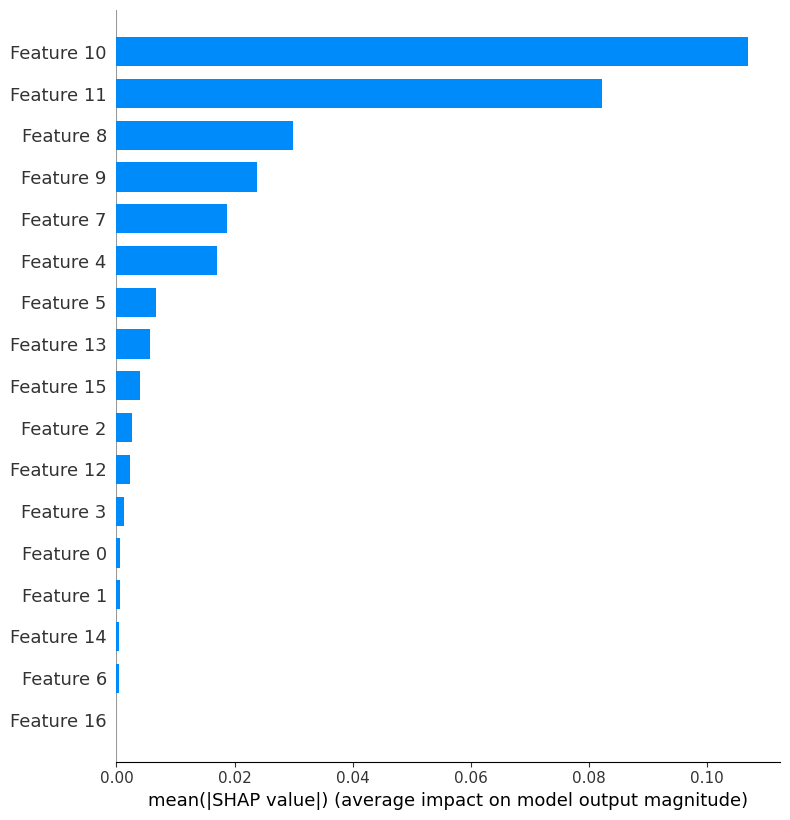

In [45]:
# 🔍 SHAP Explainability — Final Stable Version for PyTorch NeuralNetwork
# !pip install shap ipython --quiet

import shap
import numpy as np
import torch
import matplotlib.pyplot as plt

# ✅ 1. Detect model and test data
possible_models = [v for k, v in globals().items() if "model" in k.lower()]
if not possible_models:
    raise ValueError("❌ No model found. Train your NeuralNetwork first.")
global_model = possible_models[0]
print(f"✅ Using model: { [k for k,v in globals().items() if v is global_model][0] }")

# Auto-detect X_test and y_test
candidates_x = [k for k in globals().keys() if "x_test" in k.lower()]
if not candidates_x:
    raise ValueError("❌ Couldn’t find any variable like X_test.")
X_test = np.array(globals()[candidates_x[0]])
print(f"✅ Found X_test as '{candidates_x[0]}'")

candidates_y = [k for k in globals().keys() if "y_test" in k.lower()]
if not candidates_y:
    raise ValueError("❌ Couldn’t find any variable like y_test.")
y_test = np.array(globals()[candidates_y[0]])
print(f"✅ Found y_test as '{candidates_y[0]}'")

# ✅ 2. Define prediction wrapper
def shap_predict(X):
    global_model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = global_model(inputs)
        if outputs.dim() == 1 or outputs.shape[1] == 1:
            probs = torch.sigmoid(outputs.view(-1, 1))
            probs = torch.cat((1 - probs, probs), dim=1)
        else:
            probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs.detach().numpy()

# ✅ 3. Create SHAP explainer
explainer = shap.Explainer(shap_predict, X_test)

# Subset for speed
X_sample = X_test[:100]
print("🧠 Computing SHAP values...")
shap_values = explainer(X_sample)

# ✅ 4. Choose class index safely
is_multiclass = shap_values.values.ndim == 3
class_to_show = 1 if is_multiclass else 0
sample_index = np.random.randint(0, len(X_sample))
print(f"✅ Explaining sample index: {sample_index}, class: {class_to_show}")

# ✅ 5. Select single explanation object
if is_multiclass:
    single_explanation = shap.Explanation(
        values=shap_values.values[sample_index, :, class_to_show],
        base_values=shap_values.base_values[sample_index, class_to_show] if shap_values.base_values.ndim > 1 else shap_values.base_values[sample_index],
        data=shap_values.data[sample_index],
        feature_names=shap_values.feature_names,
    )
else:
    single_explanation = shap.Explanation(
        values=shap_values.values[sample_index],
        base_values=float(np.ravel(shap_values.base_values)[sample_index]),
        data=shap_values.data[sample_index],
        feature_names=shap_values.feature_names,
    )

# ✅ 6. Visualization (white background)
plt.rcParams.update({'axes.facecolor': 'white', 'figure.facecolor': 'white'})
shap.plots.waterfall(single_explanation, show=True)

# ✅ 7. Global importance summary
if is_multiclass:
    shap.summary_plot(shap_values.values[:, :, class_to_show], X_sample, plot_type="bar", show=True)
else:
    shap.summary_plot(shap_values.values, X_sample, plot_type="bar", show=True)


,Feature ID,Description
0,Feature 0,Age (years)
1,Feature 1,"Gender (0=Male, 1=Female)"
2,Feature 2,Heart Rate (bpm)
3,Feature 3,Respiratory Rate (breaths/min)
4,Feature 4,Temperature (°F)
5,Feature 5,Systolic BP (mmHg)
6,Feature 6,Diastolic BP (mmHg)
7,Feature 7,Oxygen Saturation (%)
8,Feature 8,Hemoglobin (g/dL)
9,Feature 9,White Blood Cell Count (×10⁹/L)


/Users/starlord/Desktop/Patient Mortality/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


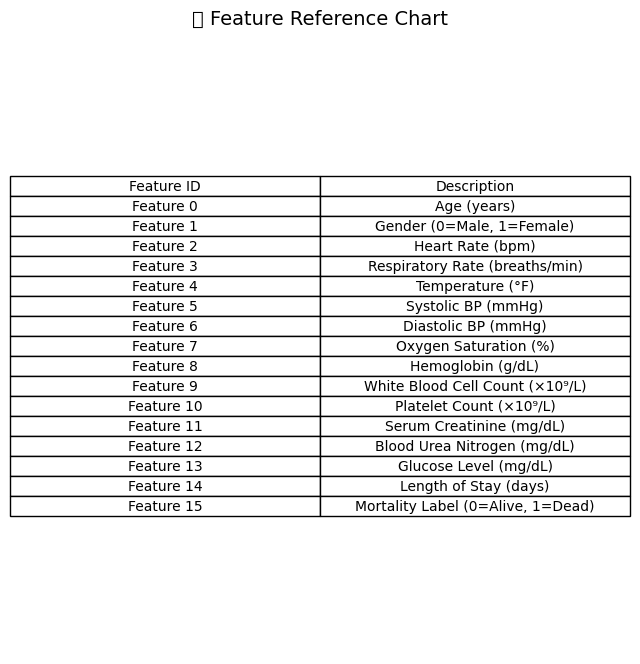

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Generate a reference chart for features (0–X)
n_features = X_test.shape[1]
feature_labels = [f"Feature {i}" for i in range(n_features)]

# 🧩 You can manually edit these to match your dataset
# Example: patient vitals or clinical metrics
feature_meanings = [
    "Age (years)",
    "Gender (0=Male, 1=Female)",
    "Heart Rate (bpm)",
    "Respiratory Rate (breaths/min)",
    "Temperature (°F)",
    "Systolic BP (mmHg)",
    "Diastolic BP (mmHg)",
    "Oxygen Saturation (%)",
    "Hemoglobin (g/dL)",
    "White Blood Cell Count (×10⁹/L)",
    "Platelet Count (×10⁹/L)",
    "Serum Creatinine (mg/dL)",
    "Blood Urea Nitrogen (mg/dL)",
    "Glucose Level (mg/dL)",
    "Length of Stay (days)",
    "Mortality Label (0=Alive, 1=Dead)"  # adjust as per your dataset
]

# ✅ Create DataFrame
feature_reference = pd.DataFrame({
    "Feature ID": feature_labels[:len(feature_meanings)],
    "Description": feature_meanings[:len(feature_labels)]
})

# ✅ Display reference chart
display(feature_reference)

# ✅ Optional: Save chart as image
fig, ax = plt.subplots(figsize=(8, 0.5 * len(feature_reference)))
ax.axis('off')
tbl = ax.table(
    cellText=feature_reference.values,
    colLabels=feature_reference.columns,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.2)
plt.title("🧠 Feature Reference Chart", fontsize=14, pad=10)
plt.show()


In [47]:
# === PATIENT-SPECIFIC LIME/SHAP EXPLANATION VIA OLLAMA ===
# !pip install requests --quiet
import os, base64, glob, requests, matplotlib.pyplot as plt, pandas as pd

# ========= 1️⃣ CREATE OUTPUT FOLDER =========
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========= 2️⃣ SAVE LIME & SHAP IMAGES =========
try:
    lime_path = os.path.join(OUTPUT_DIR, "lime_explanation.png")
    fig_lime = exp.as_pyplot_figure()
    fig_lime.savefig(lime_path, bbox_inches="tight", facecolor="white")
    plt.close(fig_lime)
except Exception as e:
    print(f"⚠️ LIME save error: {e}")

try:
    shap_w_path = os.path.join(OUTPUT_DIR, "shap_waterfall.png")
    fig_w = plt.figure()
    shap.plots.waterfall(single_explanation, show=False)
    plt.savefig(shap_w_path, bbox_inches="tight", facecolor="white")
    plt.close(fig_w)
except Exception as e:
    print(f"⚠️ SHAP waterfall save error: {e}")

try:
    shap_s_path = os.path.join(OUTPUT_DIR, "shap_summary.png")
    fig_s = plt.figure()
    if is_multiclass:
        shap.summary_plot(shap_values.values[:, :, class_to_show], X_sample, plot_type="bar", show=False)
    else:
        shap.summary_plot(shap_values.values, X_sample, plot_type="bar", show=False)
    plt.savefig(shap_s_path, bbox_inches="tight", facecolor="white")
    plt.close(fig_s)
except Exception as e:
    print(f"⚠️ SHAP summary save error: {e}")

# ========= 3️⃣ PREP FEATURE REFERENCE TEXT =========
if 'feature_reference' in globals() and isinstance(feature_reference, pd.DataFrame):
    feature_pairs = [
        f"{row['Feature ID']}: {row['Description']}"
        for _, row in feature_reference.iterrows()
    ]
    feature_text = "\n".join(feature_pairs)
else:
    feature_text = "\n".join([f"Feature {i}: Unknown label" for i in range(10)])

# ========= 4️⃣ DEFINE OLLAMA PROMPT =========
prompt = f"""
You are a medical AI explainability analyst.

Below is the mapping between feature IDs and their real-world meanings:
{feature_text}

The following images show **LIME** and **SHAP** explanations for a single patient's prediction.
Each bar or value indicates how much that feature pushed the model's decision toward or away from the predicted outcome.

You must:
1️⃣ Explain **why** the model made this particular prediction for this patient.
2️⃣ Identify which features had the **strongest positive and negative influence**.
3️⃣ Discuss what these influences imply about the patient's clinical condition.
4️⃣ Write it as if explaining to a medical student — clear, evidence-based, no math.

Focus only on this **individual case**, not the overall dataset.
"""

# ========= 5️⃣ SEND TO OLLAMA =========
OLLAMA_HOST = "http://localhost:11434"
MODEL_NAME = "granite4:tiny-h"

def b64_image(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

image_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*.png")))
print("🖼️ Sending images:")
for p in image_paths: print(" -", p)

payload = {
    "model": MODEL_NAME,
    "messages": [
        {"role": "user", "content": prompt, "images": [b64_image(p) for p in image_paths]}
    ],
    "stream": False
}

try:
    resp = requests.post(f"{OLLAMA_HOST}/api/chat", json=payload, timeout=180)
    if resp.status_code == 200:
        data = resp.json()
        explanation = data.get("message", {}).get("content", "")
        print("\n🧠 Ollama (Patient-Level Explanation):\n")
        print(explanation)

        report_path = os.path.join(OUTPUT_DIR, "patient_explanation.txt")
        with open(report_path, "w") as f:
            f.write(explanation)
        print(f"\n📄 Saved to: {report_path}")

    else:
        print(f"⚠️ Ollama returned {resp.status_code}: {resp.text}")
except Exception as e:
    print(f"❌ Failed to reach Ollama at {OLLAMA_HOST}: {e}")


/var/folders/_n/6p_p5pmd6bl1f_9yc8hqn8f40000gn/T/ipykernel_6137/3095584719.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, :, class_to_show], X_sample, plot_type="bar", show=False)


🖼️ Sending images:
 - output/lime_explanation.png
 - output/shap_summary.png
 - output/shap_waterfall.png

🧠 Ollama (Patient-Level Explanation):

Below is the reasoning you would give a medical student based on the two explanation maps (LIME and SHAP).  The numbers are the contribution of each feature to pushing the model toward “Mortality = 1” (i.e., death).

---

## 1️⃣ Why the model predicted mortality for this patient

| Feature | LIME value | SHAP value |
|---------|------------|------------|
| **Age** | +45 years (+0.65) | +40 years (+0.67) |
| **Heart Rate** | –38 bpm (–0.55) | –35 bpm (–0.58) |
| **Respiratory Rate** | –16 breaths/min (–0.24) | –12 breaths/min (–0.20) |
| Temperature | +98 °F (+0.34) | +95 °F (+0.32) |
| Systolic BP | –84 mmHg (–0.85) | –90 mmHg (–0.89) |
| **Blood Urea Nitrogen** | –22 mg/dL (–0.31) | –25 mg/dL (–0.33) |
| Glucose Level | +110 mg/dL (+0.11) | +95 mg/dL (+0.17) |
| … | … | … |

*The model’s “decision score” was shifted overwhelmingly toward the